#### Import the facialextractor

In [1]:
from facialextractor import FacialExtractor
import random
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

2024-07-09 15:34:50.090358: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-09 15:34:50.097771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 15:34:50.108631: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 15:34:50.108648: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-09 15:34:50.115927: I tensorflow/core/platform/cpu_feature_gua

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

#### Load random image

In [3]:
puredt_path = '/mnt/disk2/PURE'

In [4]:
# random subject from 1 - 10
ran_sub = random.randint(1, 10)
ran_rec = random.randint(1, 6)

# change the format into two digits
folder_name = str(ran_sub).zfill(2) + '-' + str(ran_rec).zfill(2)
print(f"Folder name: {folder_name}")

# populate the `png` files
png_files = os.listdir(os.path.join(puredt_path, folder_name))
print(f"Total number of files: {len(png_files)}")

Folder name: 10-03
Total number of files: 2300


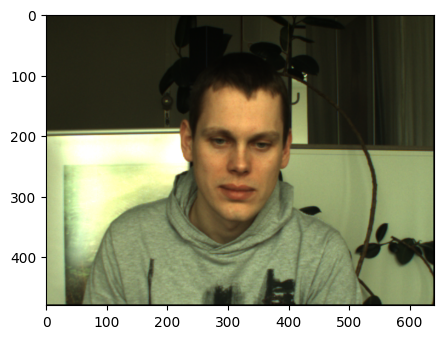

In [5]:
# select a random image
ran_img = random.choice(png_files)
img = cv2.imread(os.path.join(puredt_path, folder_name, ran_img))
img_prv = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5, 5))
plt.imshow(img_prv); plt.axis('on'); plt.show()

#### Try the `detect_face_bbox`

In [6]:
facial_extractor = FacialExtractor()
bbox = facial_extractor.detect_face_bbox(image=img)

I0000 00:00:1720510491.822470 1001458 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720510491.928968 1001614 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 545.23.08), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1720510491.950252 1001597 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1720510491.953710 1001612 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


visualize the bbox

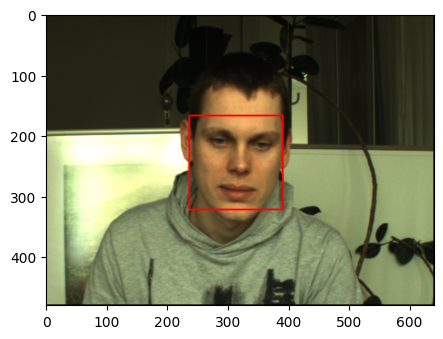

Bounding box width: 154 | height: 155


In [7]:
plt.figure(figsize=(5, 5))
plt.imshow(cv2.rectangle(img_prv, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)); plt.axis('on'); plt.show()
# calculate the bbox width and height
bbox_width = bbox[2] - bbox[0]
bbox_height = bbox[3] - bbox[1]
print(f"Bounding box width: {bbox_width} | height: {bbox_height}")


#### Try to mask the face

In [8]:
cropped_face = facial_extractor.crop_img(image=img, bbox=bbox)

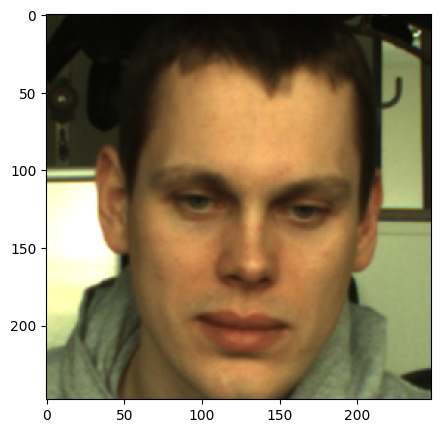

Cropped face shape: (248, 248, 3)


In [9]:
plt.figure(figsize=(5, 5))
plt.imshow(cropped_face); plt.axis('on'); plt.show()
print(f"Cropped face shape: {cropped_face.shape}")

#### Try to detect the forehead

In [10]:
interest_point = facial_extractor.detect_lm(image=cropped_face)
cropped_face_prev = cropped_face.copy()
print(f"Interest point: {interest_point}")

Interest point: [(132, 164), (170, 173), (78, 155)]


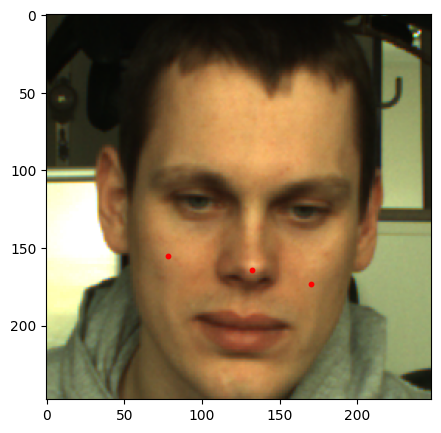

In [11]:
# visualize the interest point
plt.figure(figsize=(5, 5))
plt.imshow(cropped_face_prev)
for i, point in enumerate(interest_point):
    plt.scatter(point[0], point[1], c='r', s=10)

#### Segment Face

In [12]:
masks, scores, logits = facial_extractor.segment_face(
    image=cropped_face,
    interest_point=interest_point,
)

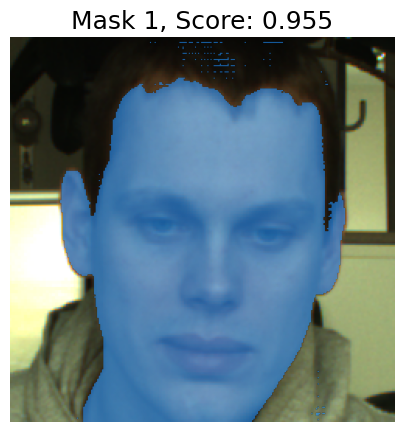

In [13]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(5,5))
    plt.imshow(cropped_face)
    show_mask(mask, plt.gca())
    # show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() 

#### Extract Face Skin

In [14]:
face_skin_img = facial_extractor.extract_face_skin(
    image=cropped_face,
    mask=masks,
)

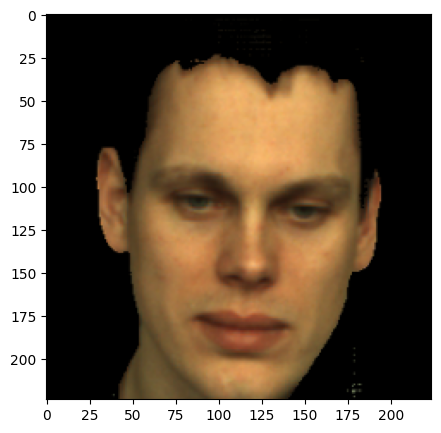

In [15]:
plt.figure(figsize=(5, 5))
plt.imshow(face_skin_img); plt.axis('on'); plt.show()